Breed Classification CNN using Transfer Learning

In [1]:
import pandas as pd
import os, shutil
import numpy as np

In [2]:
import tensorflow
from tensorflow.compat.v1.keras.backend import set_session
config = tensorflow.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tensorflow.compat.v1.Session(config=config)
set_session(sess)
import tensorflow.keras.backend as K

tensorflow.compat.v1.disable_eager_execution()

File Managment

In [3]:
os.chdir("C:/Users/abbal/Documents/Py - Dog Breed Identification V3")

In [ ]:
## Create a folder for each set
TTV_Sets = ["test", "train", "validation"]
for st in TTV_Sets:
    os.mkdir(os.path.join("./Categorized" , st))

In [ ]:
directory_list = list()
dog_breeds = list()
for root, dirs, files in os.walk("./images/Images", topdown=False):
    for name in dirs:
        directory_list.append(os.path.join(root, name))
        dog_breeds.append(name)

TTV_Sets = ["train", "test", "validation"]        
for st in TTV_Sets:
    for i in dog_breeds:     
        os.mkdir(os.path.join("./Categorized",st, i))

In [ ]:
## split labels to train, test and validation
def train_validate_test_split(array, train_percent=0.80, validate_percent=.2, seed=1):
    np.random.seed(seed)
    perm = np.random.permutation(array)
    m = len(array)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = perm[:train_end]
    validate = perm[train_end:validate_end]
    test = perm[validate_end:]
    return train, validate, test

In [ ]:
for fld in range(len(directory_list)):

    TempFLDR = directory_list[fld]
    TempDogBreed = dog_breeds[fld]
    
    ## Get files in folder
    fles = []
    for (dirpath, dirnames, filenames) in os.walk(TempFLDR):
        fles.extend(filenames)
        break

    ## split the files into train, test, validation
    train, validate, test = train_validate_test_split(fles)

    ## Copy each file in their respective folder
    for fle in range(len(train)):
        Orig_file = os.path.join(TempFLDR, train[fle])
        New_file = os.path.join("./Categorized/train",TempDogBreed, train[fle])
        shutil.copyfile(Orig_file, New_file)

    for fle in range(len(validate)):
        Orig_file = os.path.join(TempFLDR, validate[fle])
        New_file = os.path.join("./Categorized/validation",TempDogBreed, validate[fle])
        shutil.copyfile(Orig_file, New_file)

    for fle in range(len(test)):
        Orig_file = os.path.join(TempFLDR, test[fle])
        New_file = os.path.join("./Categorized/test",TempDogBreed, test[fle])
        shutil.copyfile(Orig_file, New_file)


In [4]:
train_dir = os.path.join("./Categorized", 'train')
validation_dir = os.path.join("./Categorized", 'validation')
test_dir = os.path.join("./Categorized", 'test')

Build model using pre-trained InceptionResNetV2. Transfer learning by updating the final layer of the network

In [6]:
## let's use ResNet50
## Let's also increase the image processing size to 300x300
from keras.applications import InceptionResNetV2

conv_base = InceptionResNetV2(weights='imagenet', 
                              include_top=False,
                              input_shape=(300, 300, 3))

In [7]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(120, activation='softmax'))

In [8]:
## Fix base model so it doesn't train.
conv_base.trainable = False

In [9]:
from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
conv2d_406 (Conv2D)          (None, 6, 6, 1024)        14156800  
_________________________________________________________________
conv2d_407 (Conv2D)          (None, 4, 4, 1024)        9438208   
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4195328   
_________________________________________________________________
dense_1 (Dense)              (None, 120)               1

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input, decode_predictions

## Process images by:
## using inception pre-processing function
## adding some distortion to the images
train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=25,
      width_shift_range=0.15,
      height_shift_range=0.15,
      shear_range=0.15,
      zoom_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')

## Don't validate test images
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(300, 300),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(300, 300),
        batch_size=32,
        class_mode='categorical')

Found 16425 images belonging to 120 classes.
Found 4073 images belonging to 120 classes.


In [12]:
## Only train for 30 epochs, since that will get us closer to the 90% accuracy
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=100)

Epoch 1/10
100/100 [==============================] - 58s 576ms/step - loss: 2.7955 - acc: 0.4156 - val_loss: 0.6609 - val_acc: 0.8213
Epoch 2/10
100/100 [==============================] - 56s 560ms/step - loss: 1.4336 - acc: 0.6569 - val_loss: 0.4771 - val_acc: 0.8732
Epoch 3/10
100/100 [==============================] - 55s 548ms/step - loss: 1.2519 - acc: 0.6928 - val_loss: 0.5245 - val_acc: 0.8687
Epoch 4/10
100/100 [==============================] - 55s 547ms/step - loss: 1.2023 - acc: 0.7106 - val_loss: 0.4714 - val_acc: 0.8703
Epoch 5/10
100/100 [==============================] - 55s 550ms/step - loss: 1.1647 - acc: 0.7172 - val_loss: 0.5118 - val_acc: 0.8678
Epoch 6/10
100/100 [==============================] - 55s 549ms/step - loss: 1.0586 - acc: 0.7394 - val_loss: 0.4295 - val_acc: 0.8854
Epoch 7/10
100/100 [==============================] - 54s 541ms/step - loss: 1.0762 - acc: 0.7300 - val_loss: 0.4851 - val_acc: 0.8759
Epoch 8/10
100/100 [==============================] - 5

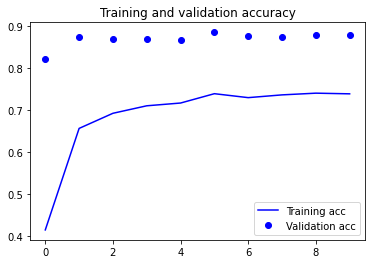

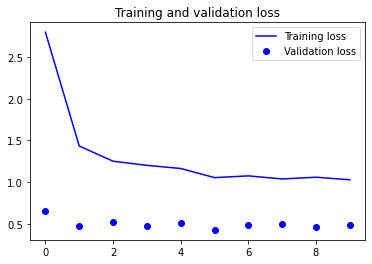

In [13]:
## Let's plot model performance
## Interesting that test performance starts really high
## but doesn't really improve over time.
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Let's use CAM-Grad to understand what the network is looking at.

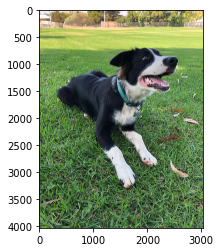

In [14]:
from tensorflow.keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input, decode_predictions

# The local path to our target image
img_path = "C:/Users/abbal/Pictures/Snake 3.jpg"

# `img` is a PIL image of size 224x224
img_actual = image.load_img(img_path)
img = image.load_img(img_path, target_size=(300, 300))

# `x` is a float32 Numpy array of shape (300, 300, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 300, 300, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

plt.imshow(img_actual)

In [15]:
## Get image prediction

preds = model.predict(x)
NumPredicted = np.argmax(preds[0])

Prediction_Dictionary = dict(zip(train_generator.class_indices, np.round(preds[0]*100,2)))
Sorted_Prediction_Dictionary = sorted(Prediction_Dictionary.items(), key=lambda x: x[1], reverse=True)

In [16]:
## How many have a prediction above 2%
Count_5Perc = preds[0][preds[0]>0.02]

if len(Count_5Perc) == 1:
    TopPredictions = Sorted_Prediction_Dictionary[0]
if len(Count_5Perc) > 1:
    TopPredictions = Sorted_Prediction_Dictionary[0:len(Count_5Perc)]

print(TopPredictions)

[('n02106166-Border_collie', 89.31), ('n02107908-Appenzeller', 6.56)]


In [17]:
## Great! the model as able to predict my border collie "Snake"

## Create heatmap for the second to last layer of the CNN
## The second to last layet is directly connected to the base of 
## the pre-trained network

preds = model.predict(x)
argmax = np.argmax(preds[0])
output = model.output[:, argmax]
last_conv_layer = model.get_layer('conv2d_406')
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(1024):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)


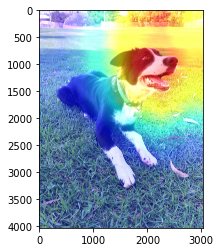

In [18]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.6 + img

cv2.imwrite('./Snake 3 - Grad Cam.jpg', superimposed_img)

Grad_Image = image.load_img('./Snake 3 - Grad Cam.jpg')
plt.imshow(Grad_Image)

It looks like the network was mostly focused on its head. Most likely because the white stripe on border collies is a telltale sign of their breed